In [13]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q stanza
import stanza
stanza.download('en', verbose=False)

import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

#### Preprocessing the data:

In [2]:
data = pd.read_csv('train_2024.csv', quoting = 3)   # id, text and label
labels = np.array( data['label'] )[:5000]
comments = np.array( data['text'] )[:5000]

print('Preprocessing the data...')

nlp = stanza.Pipeline(lang='en', processors='tokenize, lemma',  verbose=False)
comments = [nlp(x).sentences for x in comments]
comments = [[sent.words for sent in comment] for comment in comments]

normalised_comments = []
for comment in comments:
    new_comment = []
    for sent in comment:
        for word in sent:
            lemma = word.lemma.lower()
            if lemma not in stopwords and lemma.isalpha():
                new_comment.append(lemma)
    normalised_comments.append(new_comment)
    
print('Preprocessing done!')

comments_train, comments_test, labels_train, labels_test = train_test_split(normalised_comments, labels, train_size = 0.6)

Preprocessing the data...
Preprocessing done!


#### Computing the features of the training data:

In [3]:
def create_matrix(comments):
    vocab = set()
    for comment in comments:
        vocab.update(comment)
    sorted_vocab = sorted(vocab)

    rows = len(sorted_vocab)
    columns = len(comments)
    matrix = np.zeros((rows,columns))

    for i in range(columns):
        comment = comments[i]
        count = collections.Counter(comment)
        for word in count:
            matrix[sorted_vocab.index(word),i] = count[word]
    return matrix, sorted_vocab

In [4]:
def tf_idf(matrix):
    rows, columns = matrix.shape
    tf_idf_matrix = np.zeros((rows,columns))
    idf_vector = np.zeros((rows,1))
    
    for i in range(rows):
        d_ft = np.count_nonzero(matrix[i,:])
        for j in range(columns):
            tf = matrix[i][j]
            idf = np.log10(columns / d_ft)
            
            tf_idf_matrix[i,j] = tf * idf
            idf_vector[i] = idf
    
    return tf_idf_matrix, idf_vector      

In [5]:
matrix_train, sorted_vocab = create_matrix(comments_train)
tf_idf_matrix, idf_vector = tf_idf(matrix_train)

n_topics = 250
tf_idf_svd = TruncatedSVD(n_components = n_topics)
tf_idf_matrix_dense = tf_idf_svd.fit_transform(tf_idf_matrix.T).T

#### Computing the features of the test set:

In [6]:
def create_matrix_queries(comments, sorted_vocab):
    rows = len(sorted_vocab)
    columns = len(comments)
    matrix = np.zeros((rows,columns))
    
    for i in range(columns):
        comment = comments[i]
        count = collections.Counter(comment)
        for word in count:
            if word in sorted_vocab:
                matrix[sorted_vocab.index(word),i] = count[word]
    return matrix   

In [7]:
queries = create_matrix_queries(comments_test, sorted_vocab)
tf_idf_queries = queries * idf_vector
tf_idf_queries_dense = tf_idf_svd.transform(tf_idf_queries.T).T

#### Gathering the features in panda DataFrames:

In [8]:
pd_train = pd.DataFrame(columns = range(n_topics), index = range(len(comments_train)))
for i in range(len(comments_train)):
    pd_train.loc[i] = tf_idf_matrix_dense[:,i]
    
pd_test = pd.DataFrame(columns = range(n_topics), index = range(len(comments_test)))
for i in range(len(comments_test)):
    pd_test.loc[i] = tf_idf_queries_dense[:,i]

#### Implementing a random forest:

In [32]:
rf = RandomForestClassifier(criterion = 'log_loss', random_state = 0)
rf.fit(pd_train, labels_train)
rf_labels_prediction = rf.predict(pd_test)

#### Results (Random Forest):

In [33]:
rf_precision = precision_score(labels_test, rf_labels_prediction)
rf_accuracy = accuracy_score(labels_test, rf_labels_prediction)
rf_f1 = f1_score(labels_test, rf_labels_prediction)

print('Precision: ', rf_precision)
print('Accuracy: ', rf_accuracy)
print('F1 score: ', rf_f1)

Precision:  0.8118081180811808
Accuracy:  0.709
F1 score:  0.43052837573385516


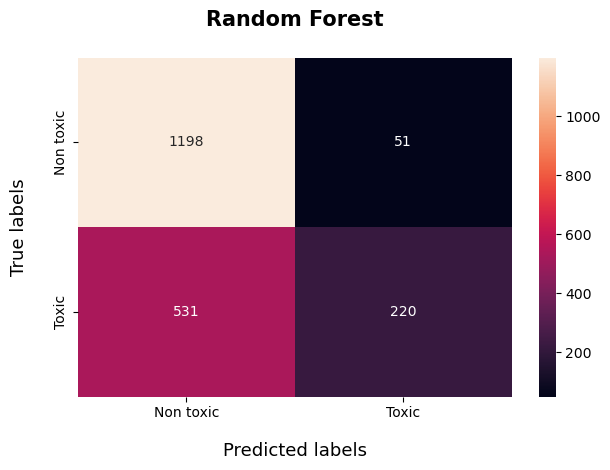

In [34]:
fig, ax = plt.subplots(1, 1)

conf_mat = confusion_matrix(labels_test, rf_labels_prediction)
sns.heatmap(conf_mat, annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 13)
ax.set_ylabel('True labels\n', fontsize = 13)
ax.set_title('Random Forest\n', fontsize = 15, weight = 'bold')
ax.xaxis.set_ticklabels(['Non toxic', 'Toxic\n'], fontsize = 10)
ax.yaxis.set_ticklabels(['Non toxic', 'Toxic'], fontsize = 10)

fig.tight_layout()

#### Implementing a multipercepytron classifier (MLP Classifier):

In [23]:
mlp = MLPClassifier(hidden_layer_sizes = 1000, max_iter = 1000)
mlp.fit(pd_train, labels_train)
mlp_labels_prediction = mlp.predict(pd_test)

#### Results (MLP Classifier):

In [24]:
mlp_precision = precision_score(labels_test, mlp_labels_prediction)
mlp_accuracy = accuracy_score(labels_test, mlp_labels_prediction)
mlp_f1 = f1_score(labels_test, mlp_labels_prediction)

print('Precision: ', mlp_precision)
print('Accuracy: ', mlp_accuracy)
print('F measure: ', mlp_f1)

Precision:  0.7239819004524887
Accuracy:  0.773
F measure:  0.6789250353606789


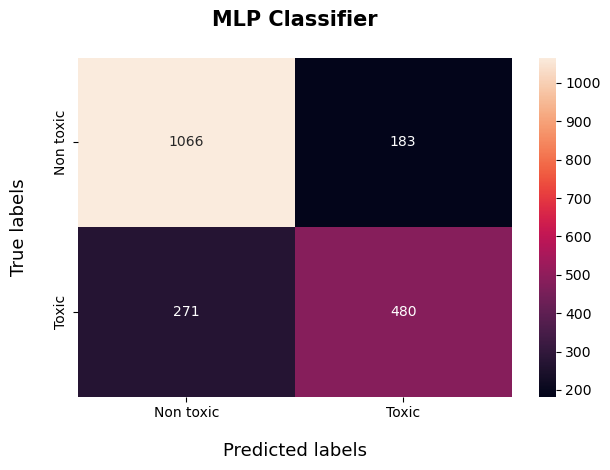

In [25]:
fig, ax = plt.subplots(1, 1)

conf_mat = confusion_matrix(labels_test, mlp_labels_prediction)
sns.heatmap(conf_mat, annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 13)
ax.set_ylabel('True labels\n', fontsize = 13)
ax.set_title('MLP Classifier\n', fontsize = 15, weight = 'bold')
ax.xaxis.set_ticklabels(['Non toxic', 'Toxic\n'], fontsize = 10)
ax.yaxis.set_ticklabels(['Non toxic', 'Toxic'], fontsize = 10)

fig.tight_layout()